

Esse trabalho foi desenvolvido para a disciplina

SME0142 - Álgebra Linear e Aplicações (2023)


Docente: Maria Luísa Bambozzi de Oliveira

Elaborado pelos alunos:

Artur De Vlieger Lima - nroUSP : 13671574

Enzo Nunes Sedenho - nroUSP : 13671810

Luiz Felipe Schulz Coria - nroUSP : 13732769

Pedro Augusto Monteiro Delgado - nroUSP : 13672766

A ideia do trabalho é, a partir de um dataset presente no Kaggle (https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset) que possui livros e avaliações dadas por usuários, utilizar conceitos de algebra linear(SVD mais especificamente) para construir um sistema de recomendação.

Link para uma apresentação de slides com uma apresentação geral do assunto https://docs.google.com/presentation/d/1FKET3okJzSOf2LepCs0_RVg1JE8ftL9hIGGJ2pi5eUQ/edit#slide=id.p



In [ ]:
import pandas as pd
import numpy as np
from scipy.linalg import svd
import requests
import zipfile
import io

#Baixando dados

In [ ]:
# Localização dos Datasets
zip_url = 'https://github.com/luizschulz/Datasets/raw/main/Data.zip'

# Fazendo o download dos Dataset
response = requests.get(zip_url)
zip_content = response.content

# Deszipando cada um
with zipfile.ZipFile(io.BytesIO(zip_content), 'r') as zip_ref:
    zip_ref.extractall("extracted_folder")


# Classes e funções utilizadas

In [ ]:
class Data:
    """
    Uma classe para gerenciar dados de livros e avaliações.

    Esta classe é projetada para ler e processar dados de livros e avaliações de usuários a partir de arquivos CSV.
    Inclui métodos para filtrar usuários e livros com base no número de avaliações,
    mesclar dados e criar uma representação matricial dos dados.

    Atributos:
        books (DataFrame): DataFrame para armazenar dados de livros.
        ratings (DataFrame): DataFrame para armazenar avaliações de usuários.
        data (DataFrame): Dados combinados de livros e avaliações.
        matrix (DataFrame): Representação matricial das avaliações dos usuários.
        movies_dict (dict): Dicionário para armazenar dados de filmes (não implementado nos métodos fornecidos).

    Métodos:
        read_csvs(books, ratings): Lê dados de livros e avaliações de arquivos CSV.
        filter_users_by_rating_count(rating_count=200): Filtra usuários com base em um número mínimo de avaliações.
        merge_data(): Mescla os dados de livros e avaliações com base no ISBN.
        filter_books_by_rating_count(rating_count=50): Filtra livros com base em um número mínimo de avaliações.
        creating_matrix(): Cria uma matriz a partir do DataFrame onde colunas são Títulos de Livros,
                           linhas são IDs de Usuários e os valores são avaliações.
        getMatrix(user_ratings_count=200, books_ratings_count=50): Processa os dados e retorna a representação matricial.
    """

    def __init__(self):
        self.books = None
        self.ratings = None
        self.data = None
        self.matrix = None
        self.movies_dict = None


    def read_csvs(self, books, ratings):
        # Le os CSVs
        self.books = pd.read_csv('extracted_folder/Data/' + books)
        self.ratings = pd.read_csv('extracted_folder/Data/' + ratings)


    def filter_users_by_rating_count(self, rating_count=200):
        # Pegando a quantidade de ratings de cada usuário
        user_rating_counts = self.ratings["User-ID"].value_counts()

        # Pegando os usuário com a quantidade de ratings maior que o determinado
        users_over_X_ratings = user_rating_counts > rating_count

        # Pegar a lista dos Ids dos usuários que possuem mais de X ratings
        selected_user_ids = user_rating_counts[users_over_X_ratings].index

        # Filtra o DataFrame para ter apenas esses usuário
        self.ratings = self.ratings[self.ratings["User-ID"].isin(selected_user_ids)]

    def merge_data(self):
        ## junta os dois csvs pelo id do livro
        self.data = pd.merge(self.ratings, self.books, on="ISBN", how="inner")

        # Filtra as colunas para apenas as que serão usadas
        self.data = self.data[["User-ID", "ISBN", "Book-Title", "Book-Rating"]]

    def filter_books_by_rating_count(self, rating_count=50):
        # Calcula a quantidade de ratings e cada livro
        book_rating_counts = self.data.groupby('Book-Title')['Book-Rating'].count().reset_index()

        # Renomeia a coluna para
        book_rating_counts.rename(columns={'Book-Rating': 'number_of_ratings'}, inplace=True)

        # Junta o DataFrame original com a quantidade de ratings
        merged_ratings = self.data.merge(book_rating_counts, on='Book-Title')

        # Filtra o DataFrame para livros com mais que X ratings
        books_with_many_ratings = merged_ratings[merged_ratings['number_of_ratings'] >= rating_count]

        # Remove ratings de usuário para o mesmo livro duplicados
        self.data = books_with_many_ratings.drop_duplicates(['User-ID', 'Book-Title'])

    def creating_matrix(self):
        ## Cria uma matrix do DataFrame, as colunas sendo oo Títulos dos Livros,
        ## As linhas representando os usuários e os valores o rating.
        self.matrix = self.data.pivot_table(columns='Book-Title', index='User-ID', values="Book-Rating")

        ## Substitui os valores NA para 0
        self.matrix.fillna(0, inplace=True)

    def getMatrix(self, user_ratings_count=200, books_ratings_count=50):
        self.filter_users_by_rating_count(user_ratings_count)
        self.merge_data()
        self.filter_books_by_rating_count(books_ratings_count)
        self.creating_matrix()

        return self.matrix


In [ ]:
class Model:
    """
    Uma classe para realizar a decomposição em valores singulares (SVD) de uma matriz.

    Esta classe é projetada para aplicar o método de SVD em uma matriz fornecida e armazenar
    os componentes resultantes.

    Atributos:
        VT (DataFrame): O componente V transposto da decomposição SVD, contendo os 'k' componentes principais.
        matrix (DataFrame): A matriz original sobre a qual o SVD é aplicado.

    Métodos:
        SVD(matrix, k): Aplica a decomposição SVD na matriz fornecida e armazena os 'k' componentes principais.
    """

    def __init__(self):
        self.VT = None
        self.matrix = None

    def SVD(self, matrix, k):
        self.matrix = matrix

        _, _, VT = svd(matrix)
        VT = pd.DataFrame(VT[:k, :])
        self.VT = VT

In [ ]:
class Recomendation:

    """
    Uma classe para gerar recomendações de livros baseadas em preferências do usuário.

    Esta classe utiliza um modelo de recomendação (por exemplo, um modelo SVD) para
    sugerir novos livros com base em um livro favorito fornecido pelo usuário.

    Atributos:
        model (Model): Uma instância da classe Model que contém o método SVD e seus resultados.
        matrix (DataFrame): A matriz de avaliações de livros do modelo.
        liked_book (int): O índice do livro favorito do usuário na matriz de avaliações.
        n_recs (int): O número de recomendações a serem geradas.
        books_dict (dict): Um dicionário mapeando índices de livros para seus títulos.
        reverse_books_dict (dict): Um dicionário inverso mapeando títulos de livros para seus índices.

    Métodos:
        execute(): Executa o processo de recomendação.
        input(): Coleta o livro favorito do usuário.
        make_recommendation(): Gera recomendações com base no livro favorito.
        create_books_dict(): Cria um dicionário de livros.
        create_reverse_books_dict(): Cria um dicionário inverso de livros.
        print_recommendation(): Exibe as recomendações geradas.
    """

    def __init__(self, model, number_of_recs):
        self.model = model

        self.matrix = self.model.matrix
        self.liked_book = None
        self.n_recs = number_of_recs

        self.books_dict = None
        self.reverse_books_dict = None

    def execute(self):
        self.create_books_dict()
        self.create_reverse_books_dict()
        self.input()

        self.make_recommendation()
        self.print_recommendation()

    def input(self):
        book_name = input("Qual teu livro favorito? ")
        self.liked_book = self.reverse_books_dict[book_name]

    def make_recommendation(self):
        self.liked_book = self.liked_book

        rec = []
        for item in range(len(self.model.VT.columns)):
            if item != self.liked_book:
                rec.append([item, np.dot(self.model.VT[item], self.model.VT[self.liked_book])])
        final_rec = [i[0] for i in sorted(rec, key=lambda  x: x[1], reverse=True)]
        self.recommendations = final_rec[:self.n_recs]

    def create_books_dict(self):
        column = self.matrix.columns.to_list()
        self.books_dict = {idx: column_name for idx, column_name in enumerate(column)}


    def create_reverse_books_dict(self):
        self.reverse_books_dict = {value: key for key, value in self.books_dict.items()}

    def print_recommendation(self):

        liked_book_name = self.books_dict[self.liked_book]
        rec_books = [self.books_dict[rec] for rec in self.recommendations]

        print(f"Por você ter gostado de: {liked_book_name}\nRecomendamos: ")

        for i, rec in enumerate(rec_books):
            print(f"\t{i+1}: {rec}")

# Construindo um modelo de recomendação

In [ ]:
df = Data()
df.read_csvs("Books.csv", "Ratings.csv")
matrix = df.getMatrix(user_ratings_count=200, books_ratings_count=50)

<ipython-input-9-d2260850fdfb>:36: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  self.books = pd.read_csv('extracted_folder/Data/' + books)


In [ ]:
df.data

,User-ID,ISBN,Book-Title,Book-Rating,number_of_ratings
0,277427,002542730X,Politically Correct Bedtime Stories: Modern Ta...,10,82
1,3363,002542730X,Politically Correct Bedtime Stories: Modern Ta...,0,82
2,11676,002542730X,Politically Correct Bedtime Stories: Modern Ta...,6,82
3,12538,002542730X,Politically Correct Bedtime Stories: Modern Ta...,10,82
4,13552,002542730X,Politically Correct Bedtime Stories: Modern Ta...,0,82
...,...,...,...,...,...
236701,255489,0553579983,And Then You Die,7,50
236702,256407,0553579983,And Then You Die,0,50
236703,257204,0553579983,And Then You Die,0,50
236704,261829,0553579983,And Then You Die,0,50


In [ ]:
model = Model()
model.SVD(df.matrix, 150)

In [ ]:
number_recs = 5
recomendation = Recomendation(model, number_recs)

In [ ]:
recomendation.execute()

Qual teu livro favorito? Animal Farm
Por você ter gostado de: Animal Farm
Recomendamos: 
	1: 1984
	2: Lord of the Flies
	3: She's Come Undone (Oprah's Book Club)
	4: Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson
	5: Brave New World


# Estudos sobre como o número de dimensões(grau) afeta o sistema de recomendação

In [ ]:
# função para testar os efeitos de aumentar/diminuir o grau do SVD
def testes(data, grau_SVD):
    model = Model()
    model.SVD(df.matrix, grau_SVD)

    recomendation = Recomendation(model, number_recs)

    recomendation.execute()

Como não temos uma métrica exata para avaliar o quão boa realmente foi a recomendação feita, utilizamos o livro 5 de Harry Potter, tomando os outros livros de Harry Potter como as recomendações mais próximas possíveis

In [ ]:
# Dados analisados
df.matrix

Book-Title,1984,1st to Die: A Novel,2nd Chance,4 Blondes,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Cry In The Night,...,Winter Solstice,Wish You Well,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)",Wuthering Heights,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
User-ID,,,,,,,,,,,,,,,,,,,,,
254,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275970,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nosso conjunto de dados possui 742 colunas, então a matriz original seria o equivalente a 742 dimensões. Como podemos ver, por enquanto, nenhum outro livro do Harry Potter foi recomendado

In [ ]:
testes(df, 742)

Qual teu livro favorito? Harry Potter and the Order of the Phoenix (Book 5)
Por você ter gostado de: Harry Potter and the Order of the Phoenix (Book 5)
Recomendamos: 
	1: It Was on Fire When I Lay Down on It
	2: The Loop
	3: In Her Shoes : A Novel
	4: A Civil Action
	5: Four Blind Mice


Conforme vamos diminuindo o número de dimensões, o SVD começa a entrar em ação, diminuindo o ruído presente nos dados, e cada vez mais harry potters aparecem, com posições mais altas de recomendação

In [ ]:
testes(df, 200)

Qual teu livro favorito? Harry Potter and the Order of the Phoenix (Book 5)
Por você ter gostado de: Harry Potter and the Order of the Phoenix (Book 5)
Recomendamos: 
	1: Harry Potter and the Goblet of Fire (Book 4)
	2: When the Wind Blows
	3: Bleachers
	4: Chicken Soup for the Soul (Chicken Soup for the Soul)
	5: A Wrinkle In Time


Até que chega em um ponto que só temos Harry Potter. Nossa, perfeito, nossa modelo deve ser um dos melhores possíveis, só que não. Esse fenômeno gera um evento famoso nas redes sociais, as bolhas. Modelos que aprenderam demais limitam o indivíduo à seletas recomendações, perdendo o valor da diversidade, seja de gostos ou de opiniões. Por isso é importante ter um equilíbrio na precisão do modelo, nem muito bom, nem muito ruim.  

In [ ]:
testes(df, 20)

Qual teu livro favorito? Harry Potter and the Order of the Phoenix (Book 5)
Por você ter gostado de: Harry Potter and the Order of the Phoenix (Book 5)
Recomendamos: 
	1: Harry Potter and the Prisoner of Azkaban (Book 3)
	2: Harry Potter and the Goblet of Fire (Book 4)
	3: Harry Potter and the Chamber of Secrets (Book 2)
	4: Harry Potter and the Sorcerer's Stone (Book 1)
	5: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))


Exemplo tirado da amazon

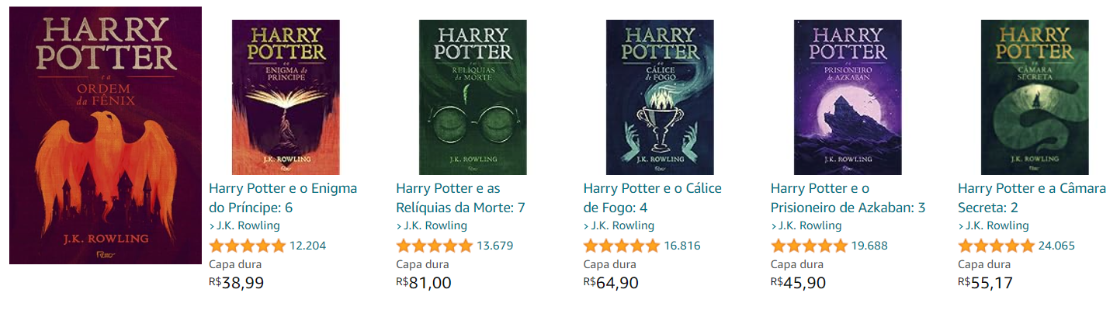

E por fim, se continuarmos diminuindo o número de dimensões, o número de informações descartadas pelo SVD cresce tanto que as recomendações perdem um pouco de sentido, mais uma vez apontando para uma escolha equilibrada no número de dimensões

In [ ]:
testes(df, 3)

Qual teu livro favorito? Harry Potter and the Order of the Phoenix (Book 5)
Por você ter gostado de: Harry Potter and the Order of the Phoenix (Book 5)
Recomendamos: 
	1: The Lovely Bones: A Novel
	2: The Red Tent (Bestselling Backlist)
	3: The Secret Life of Bees
	4: Bridget Jones's Diary
	5: The Nanny Diaries: A Novel


Portanto, é valido destacar que o grau de dimensionalidade deve ser estudado de acordo com cada aplicação, de modo que se obtenha um modelo capaz de avaliar com corretude, porém sem a criação de bolhas, cujas quais podem tornar o sistema inaplicável em um contexto real.

# Conclusão

Ao fim desta apresentação, é notável a importância da utilização do SVD, assim como outras técnicas relacionadas à álgebra linear, no contexto de sistemas de recomendação.

A aplicação do SVD mostoru-se bastante útil para o modelo, tanto para a otimização do processamento de dados quanto para a corretude das recomendações, uma vez que o ruído é significativamente reduzido.